<a href="https://colab.research.google.com/github/leonardonels/Colab-python/blob/main/MLDL_Gaussian_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
pip install onedrivedownloader

In [113]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from onedrivedownloader import download

download('https://unimore365-my.sharepoint.com/:u:/g/personal/215580_unimore_it/EXhnxAKIfcdIqSRJoFc_C6EBCT6S0CNLOYFW3ShqivC46w?e=Ii4NOp',
                                                      filename='./mnist/mnist_mnist.zip',
                                                      unzip=True)

def load_mnist_digits():
    """
    Loads mnist (original, with digits).

    Returns
    -------
    tuple:
        x_train with shape(n_train_samples, h, w)
        y_train with shape(n_train_samples,)
        x_test with shape(n_test_samples, h, w)
        y_test with shape(n_test_samples,)
    """

    x_train = np.load('mnist/x_train.npy')
    y_train = np.load('mnist/y_train.npy')

    x_test = np.load('mnist/x_test.npy')
    y_test = np.load('mnist/y_test.npy')

    label_dict = {i: str(i) for i in range(0, 10)}

    return x_train, y_train, x_test, y_test, label_dict


def load_mnist(threshold=0.5):
    """
    Loads MNIST data (either digits or fashion) and returns it binarized.

    Parameters
    ----------
    threshold: float
        a threshold in [0, 1] to binarize w.r.t.

    Returns
    -------
    tuple:
        x_train with shape(n_train_samples, h, w)
        y_train with shape(n_train_samples,)
        x_test with shape(n_test_samples, h, w)
        y_test with shape(n_test_samples,)
    """

    x_train, y_train, x_test, y_test, label_dict = load_mnist_digits()

    x_train = np.float32(x_train) / 255.
    x_train[x_train >= threshold] = 1
    x_train[x_train < threshold] = 0

    x_test = np.float32(x_test) / 255.
    x_test[x_test >= threshold] = 1
    x_test[x_test < threshold] = 0

    return x_train, y_train, x_test, y_test, label_dict

Unzipping file...


Extracting files: 100%|██████████| 4/4 [00:00<00:00, 2742.72it/s]


In [114]:
from pickle import NONE
"""
Class that models a Naive Bayes Classifier
"""

import numpy as np

class NaiveBayesClassifier:
    """
    Naive Bayes Classifier.
    Training:
    For each class, a naive likelihood model is estimated for P(X/Y),
    and the prior probability P(Y) is computed.
    Inference:
    performed according with the Bayes rule:
    P = argmax_Y (P(X/Y) * P(Y))
    or
    P = argmax_Y (log(P(X/Y)) + log(P(Y)))
    """

    def __init__(self):
        """
        Class constructor
        """

        self._classes = None
        self._n_classes = None

        self._mean = None
        self._var = None
        self._prior = None

        self._eps = np.finfo(np.float32).eps
        self._gaussian_eps = 1e-1

        # array of classes prior probabilities
        self._class_priors = []

        # array of probabilities of a pixel being active (for each class)
        self._pixel_probs_given_class = []

    def fit(self, X, Y):
        """
        Computes, for each class, a naive likelihood model (self._pixel_probs_given_class),
        and a prior probability (self.class_priors).
        Both quantities are estimated from examples X and Y.

        Then try again by using a Gaussian

        Parameters
        ----------
        X: np.array
            input MNIST digits. Has shape (n_train_samples, h, w) *with n_train_samples being the value of the pixel with heigh h and width w
        Y: np.array
            labels for MNIST digits. Has shape (n_train_samples,)
        """

        self._n_classes = len(np.unique(y_train))

        for c in range(self._n_classes):
          self._class_priors.append(sum(Y==c)/len(Y))
          images_of_c=X[Y==c]
          self._pixel_probs_given_class.append((images_of_c.mean(axis=0)).reshape(X.shape[1]*X.shape[2],))

        self._pixel_probs_given_class=np.array(self._pixel_probs_given_class)



    def o_predict(self, X, return_pred=False):
        """
        Performs inference on test data.
        Inference is performed according with the Bayes rule:
        P = argmax_Y (log(P(X/Y)) + log(P(Y)) - log(P(X)))

        Parameters
        ----------
        X: np.array
            MNIST test images. Has shape (n_test_samples, h, w).

        Returns
        -------
        prediction: np.array
            model predictions over X. Has shape (n_test_samples,)

        return np.random.randint(10, size=(X.shape[0],))
        """

        n_samples=X.shape[0]
        result=np.zeros((n_samples, self._n_classes))

        mask_ones=X==1.0
        mask_zeros=X==0.0

        for c in range(self._n_classes):
          log_class_priors=np.log(self._class_priors[c])

          log_probs_ones=mask_ones*np.log(self._pixel_probs_given_class[c]+self._eps)
          log_probs_zeros=mask_zeros*np.log(1-self._pixel_probs_given_class[c]+self._eps)

          result[:, c]=log_class_priors+np.sum((log_probs_ones + log_probs_zeros), axis=1)

        if not return_pred:
          return np.argmax(result, axis=1)
        return np.argmax(result, axis=1), result


    def compute_prior(self, Y):
        class_counts = np.bincount(Y)
        self._prior = class_counts / len(Y)

    def compute_likelihood(self, X, Y):
        n_features = X.shape[1]*X.shape[2]
        n_samples = X.shape[0]
        X=X.reshape(n_samples, n_features)

        mean = np.zeros((self._n_classes, n_features))
        var = np.zeros((self._n_classes, n_features))

        for c in range(self._n_classes):
            X_c = X[Y == c]  # Immagini della classe c
            mean[c, :] = X_c.mean(axis=0)
            var[c, :] = X_c.var(axis=0)

        # Aggiungere un limite minimo alla varianza per evitare problemi numerici
        var = np.clip(var, self._gaussian_eps, None)

        self._mean, self._var = mean, var

    def gaussian_density(self, x, mean, var):
        """
        Compute the Gaussian density function for each feature (pixel).
        Avoid division by zero by adding a small epsilon to variance.
        """
        min_prob = 1e-9  # Valore minimo per la probabilità gaussiana
        coeff = 1.0 / np.sqrt(2.0 * np.pi * var)
        exponent = np.exp(- (x - mean) ** 2 / (2 * var))
        prob = coeff * exponent
        return np.clip(prob, min_prob, None)

    def predict(self, X, return_pred=False):
        n_samples = X.shape[0]

        log_probs = np.zeros((n_samples, self._n_classes))

        for c in range(self._n_classes):
            prior_log = np.log(self._prior[c])
            likelihood_log = np.sum(np.log(self.gaussian_density(X, self._mean[c], self._var[c])), axis=1)
            log_probs[:, c] = prior_log + likelihood_log

        if not return_pred:
          return np.argmax(log_probs, axis=1)
        return np.argmax(log_probs, axis=1), log_probs


    @staticmethod
    def _estimate_pixel_probabilities(images):
        """
        [OPTIONAL!]
        Estimates pixel probabilities from data.

        Parameters
        ----------
        images: np.array
            images to estimate pixel probabilities from. Has shape (n_images, h, w)

        Returns
        -------
        pix_probs: np.array
            probabilities for each pixel of being 1, estimated from images.
            Has shape (h, w)
        """
        return None

    def get_log_likelihood_under_model(self, images, model):
        """
        [OPTIONAL!]
        Returns the likelihood of many images under a certain model.
        Naive:
        the likelihood of the image is the product of the likelihood of each pixel.
        or
        the log-likelihood of the image is the sum of the log-likelihood of each pixel.

        Parameters
        ----------
        images: np.array
            input images. Having shape (n_images, h, w).
        model: np.array
            a model of pixel probabilities, having shape (h, w)

        Returns
        -------
        lkl: np.array
            the likelihood of each pixel under the model, having shape (h, w).
        """
        return None

In [115]:
import numpy as np
import matplotlib.pyplot as plt

x_train, y_train, x_test, y_test, label_dict = load_mnist(threshold=0.5)

print(f"Training set -> number of examples: {len(x_train)}")
print(f"Test set -> number of examples: {len(x_test)}")
print('-'*30)
print(f'X -> shape: {x_train.shape}')
print(f"X -> dtype: {x_train.dtype}")
print(f"X -> min: {x_train.min()}")
print(f"X -> max: {x_train.max()}")
print(f"X -> values: {np.unique(x_train)}")
print('-'*30)
print(f"Classes: {(np.unique(y_train))}")


Training set -> number of examples: 60000
Test set -> number of examples: 10000
------------------------------
X -> shape: (60000, 28, 28)
X -> dtype: float32
X -> min: 0.0
X -> max: 1.0
X -> values: [0. 1.]
------------------------------
Classes: [0 1 2 3 4 5 6 7 8 9]


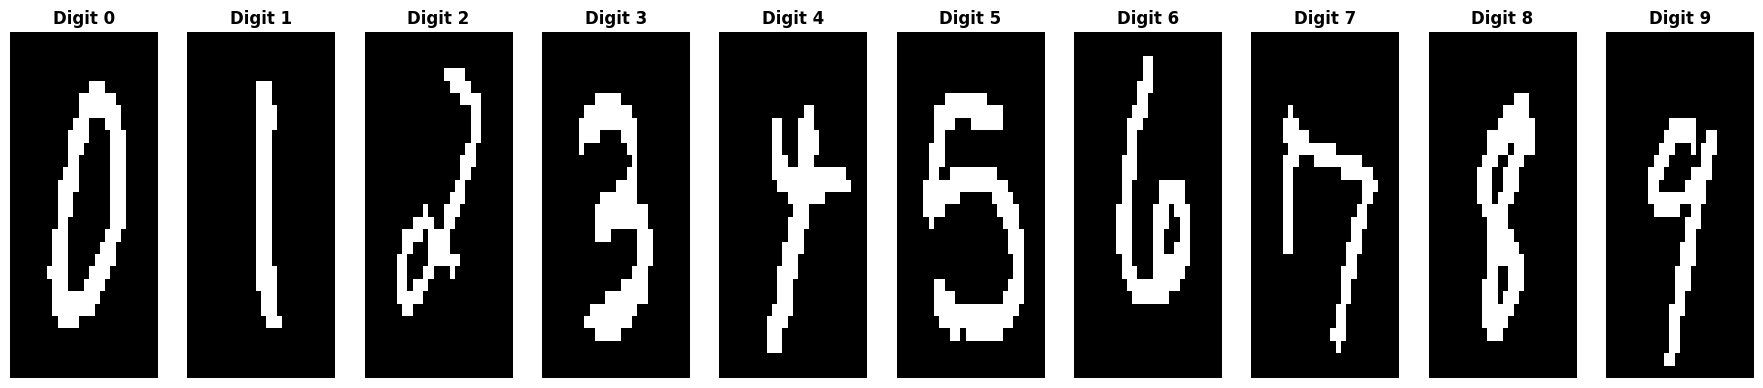

In [116]:
num_row, num_col = 1, 10
len_tr = len(x_train)
f, subplots = plt.subplots(num_row, num_col, sharex='col', sharey='row')

for cls in np.unique(y_train):
    idx = np.arange(len_tr)[y_train == cls]
    idx = np.random.choice(idx)
    X_img = x_train[idx]
    subplots[cls].imshow(X_img, cmap='gray',
                       interpolation='nearest', aspect='auto')
    subplots[cls].set_title(f'Digit {cls}', fontweight="bold")
    subplots[cls].grid(visible=False)
    subplots[cls].axis('off')

f.set_size_inches(22.5, 4.5)

**Step 1: training the Naive Bayes classifier on the training set.**

In [117]:
# get the model
nbc = NaiveBayesClassifier()

# train
nbc.fit(x_train, y_train)

nbc.compute_prior(y_train)
nbc.compute_likelihood(x_train, y_train)

**Step 2: evaluating the performance of the classifier on a set of unseen data (test set).**

Accuracy: 0.8312


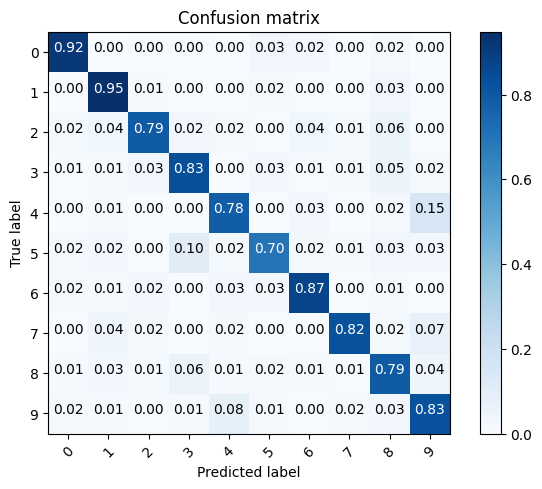

In [118]:
import itertools

def plot_confusion_matrix(targets, predictions, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    n_classes, = np.unique(targets).shape

    cm = np.zeros(shape=(n_classes, n_classes), dtype=np.float32)
    for t, p in zip(targets, predictions):
        cm[int(t), int(p)] += 1

    if normalize:
        cm /= cm.sum(axis=1)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# test
#predictions = nbc.predict(x_test.reshape((len(x_test), -1)))
predictions = nbc.predict(x_test.reshape((len(x_test), -1)))

# evaluate performances
accuracy = np.sum(np.uint8(predictions == y_test)) / len(y_test)
print('Accuracy: {}'.format(accuracy))

# show confusion matrix
plot_confusion_matrix(targets=y_test,
                      predictions=predictions,
                      classes=[label_dict[l] for l in label_dict])

Text(0.5, 1.0, 'Target: 5, Prediction: 5')

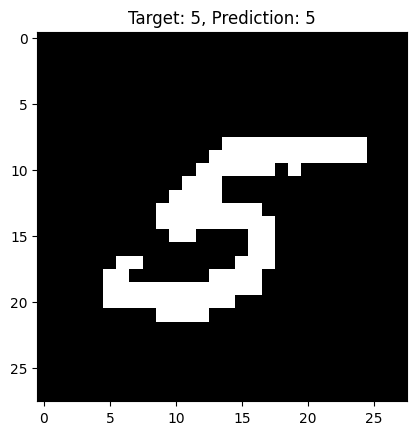

In [119]:
idx = np.random.randint(0, x_test.shape[0])

x = x_test[idx]
p = predictions[idx]
y = y_test[idx]

plt.imshow(x, cmap='gray')
plt.title('Target: {}, Prediction: {}'.format(label_dict[int(y)], label_dict[int(p)]))

In [120]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import io
from PIL import Image as PILimage

canvas_html = """
<canvas width=256 height=256></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.strokeStyle = "#FFFFFF"
ctx.fillStyle = "#000000";
ctx.fillRect(0, 0, 256, 256)
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', line_width=5, centercrop=True):
  display(HTML(canvas_html % (line_width, )))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  buf = io.BytesIO(binary)
  img = PILimage.open(buf)
  img = img.resize((28, 28), PILimage.BILINEAR)
  img = img.convert('LA')
  img = np.array(img)[:, :, 0]
  img = img > 75

  coords = np.argwhere(img)
  x_min, y_min = coords.min(axis=0)
  x_max, y_max = coords.max(axis=0)
  cropped = img[x_min:x_max+1, y_min:y_max+1]

  out_img = np.zeros((28,28))

  delta_x, delta_y = (28 - cropped.shape[0]) // 2, (28 - cropped.shape[1]) // 2
  out_img[delta_x:delta_x + cropped.shape[0], delta_y :delta_y + + cropped.shape[1]] = cropped

  return out_img.astype(np.float32)

In [ ]:
img = draw(line_width=10)
print(img.shape, img.dtype, np.unique(img))
plt.imshow(img, cmap='Greys_r')

pred, negllk = nbc.predict(img.reshape(1, 28*28), True)
classes_ord = np.arange(len(np.unique(y_test)))[np.argsort(negllk)]
classes_ord = np.flip(classes_ord)
print(f'Predicted - {pred}')
print(f'Scores: {negllk}')
print(f'Classes ordered by scores: {classes_ord}')